# Text Mining Assignment 1: Leonard

Authors:
- Bettens Bryce
- Puertolas Molina Jorge
- Tian Ying

## 1 Preprocessing 

### 1.1 Packages and Data Reading

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud

import spacy
nlp = spacy.load("en_core_web_sm")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bryce\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bryce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bryce\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [66]:
tbbt = pd.read_csv("Scripts TBBT.csv")

### 1.2 Data Preparation

In [67]:
leonard = tbbt[tbbt["person_scene"] == "Leonard"]

For the preprocessing, first, we tokenized sentences and words. After this, we performed POS tagging and NER. Lowercasing and stemming were done afterwards, since we found out that lowercasing could affect the NER, and stemming transformed names (penny was turned into penni, for instance). Stopwords were not removed, since stopwords add to the word counts in this analysis. 

In [68]:
#Process Text

#Functions for text processing (Removing stopwords and applying PorterStemmer)
def remove_stopwords(words):
    # Get the list of English stopwords
    stop_words = set(stopwords.words('english'))    
    # Filter out the stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words

def stemmer(words):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

#Tokenize sentences
leonard["sentences"] = leonard["dialogue"].apply(lambda x : sent_tokenize(x))

#Delete punctuation
leonard["dialogue"] = leonard["dialogue"].apply(lambda x : re.sub(r"[^\w\s]", "", x))

#Tokenize Words
leonard["words"] = leonard["dialogue"].apply(lambda x : word_tokenize(x))

# POS Tagging and NER

def pos_tagging(words):
    # Join the words list back into a single string
    text = " ".join(words)
    
    # Process the text with spaCy
    doc = nlp(text)
    
    # Extract POS tags
    pos_tags = [(token.text, token.pos_) for token in doc]    
    return pos_tags

def ner(words):
    text = " ".join(words)
    doc = nlp(text)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

leonard["POS"] = leonard["words"].apply(lambda x : pos_tagging(x)) 
leonard["NER"] = leonard["words"].apply(lambda x : ner(x)) 

#lowercase
def lowercasing(words):
    lowercased = [word.lower() for word in words]
    return lowercased
leonard["words"] = leonard["words"].apply(lambda x : lowercasing(x))

#Applying PorterStemmer
leonard["words"] = leonard["words"].apply(lambda x : stemmer(x))

C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\2453136048.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leonard["sentences"] = leonard["dialogue"].apply(lambda x : sent_tokenize(x))
C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\2453136048.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leonard["dialogue"] = leonard["dialogue"].apply(lambda x : re.sub(r"[^\w\s]", "", x))
C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\2453136048.py:23: SettingWithCopyWarning: 
A value is trying to be set

## 2 Answers to the Questions

### 2.1 Question 1

#### 2.1.1 Sentences and words per episode

In [69]:
#Making columns for number of sentences and words
leonard['nr_sentences'] = leonard['sentences'].apply(lambda x : len(x))
leonard['nr_words'] = leonard['words'].apply(lambda x : len(x))

#Group by episode, sum and make mean
print("Average number of sentences per episode:", leonard.groupby('episode_name')['nr_sentences'].sum().mean())
print("Average number of words per episode:", leonard.groupby('episode_name')['nr_words'].sum().mean())

Average number of sentences per episode: 61.926406926406926
Average number of words per episode: 406.4199134199134


C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\1906918137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leonard['nr_sentences'] = leonard['sentences'].apply(lambda x : len(x))
C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\1906918137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leonard['nr_words'] = leonard['words'].apply(lambda x : len(x))


#### 2.1.2 Variation across seasons

Leonard's number of lines decreases continuously throughout seasons 1-6, but then remains constant for the remaining seasons.

In [70]:
#Group by season, make mean of sums of sentences
leonard['Season'] = leonard['episode_name'].apply(lambda x : x[:9])
print(leonard.groupby(['Season', 'episode_name'])['nr_sentences'].sum().groupby('Season').mean())

Season
Series 01    91.764706
Series 02    78.695652
Series 03    75.739130
Series 04    66.541667
Series 05    61.291667
Series 06    53.416667
Series 07    54.208333
Series 08    54.208333
Series 09    49.875000
Series 10    43.500000
Name: nr_sentences, dtype: float64


C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\2356514820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leonard['Season'] = leonard['episode_name'].apply(lambda x : x[:9])


Same conclusion as for the number of lines.

In [71]:
#Group by season, make mean of sums of words
print(leonard.groupby(['Season', 'episode_name'])['nr_words'].sum().groupby('Season').mean())

Season
Series 01    666.411765
Series 02    505.391304
Series 03    474.826087
Series 04    392.791667
Series 05    390.958333
Series 06    344.666667
Series 07    363.083333
Series 08    371.083333
Series 09    329.416667
Series 10    308.375000
Name: nr_words, dtype: float64


### 2.2 Question 2

#### Data Processing

In [72]:
#Take nouns and person names from POS and NER
def select_nouns(pos):
    nouns = []
    for tuplee in pos:
        if tuplee[1] == "NOUN" and tuplee[0].lower() != "penny":
            nouns.append(tuplee[0])
    return nouns

def select_personnames(ner):
    person_names = []
    for tuplee in ner:
        if tuplee[1] == "PERSON":
            person_names.append(tuplee[0])
    return person_names

def add_penny(pos):
    times_penny = []
    for tuplee in pos:
        if tuplee[1] == "NOUN" and tuplee[0].lower() == "penny":
            times_penny.append("penny")
    return times_penny

leonard['nouns'] = leonard["POS"].apply(lambda x : select_nouns(x))
leonard['personnames'] = leonard["NER"].apply(lambda x : select_personnames(x))
leonard['penny'] = leonard["POS"].apply(lambda x : add_penny(x))
leonard['personnames'] = leonard.apply(lambda row : row['personnames'] + row['penny'], axis = 1)

#Apply lowercasing again for both nouns and person names
leonard["nouns"] = leonard["nouns"].apply(lambda x : lowercasing(x))
leonard["personnames"] = leonard["personnames"].apply(lambda x : lowercasing(x))

#Collect a list with all nouns and a list with all person names
def collect(colname):
    list_all = []
    for listt in leonard[colname]:
        list_all.extend(listt)
    return list_all

C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\3649629337.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leonard['nouns'] = leonard["POS"].apply(lambda x : select_nouns(x))
C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\3649629337.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leonard['personnames'] = leonard["NER"].apply(lambda x : select_personnames(x))
C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\3649629337.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

#### 2.2.1 How many nouns and person names are mentioned?

In [73]:
allnouns = collect("nouns")
print("Number of nouns mentioned:")
print(len(allnouns))
print("Number of unique nouns mentioned:")
print(len(set(allnouns)))

allnames = collect("personnames")
print("Number of person names mentioned:")
print(len(allnames))
print("Number of unique person names mentioned:")
print(len(set(allnames)))


Number of nouns mentioned:
12141
Number of unique nouns mentioned:
3442
Number of person names mentioned:
1382
Number of unique person names mentioned:
495


#### 2.2.2 Wordclouds and Barcharts for nouns and person names

In [74]:
#Count occurrences of each word and name
nouncounts = Counter(allnouns)
namecounts = Counter(allnames)

##### Nouns

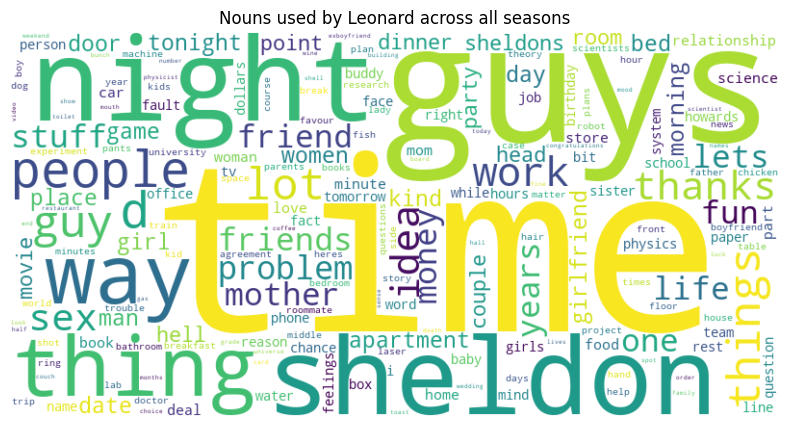

In [75]:
# Generate word cloud for nouns
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(nouncounts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Nouns used by Leonard across all seasons")
plt.axis("off")
plt.show()

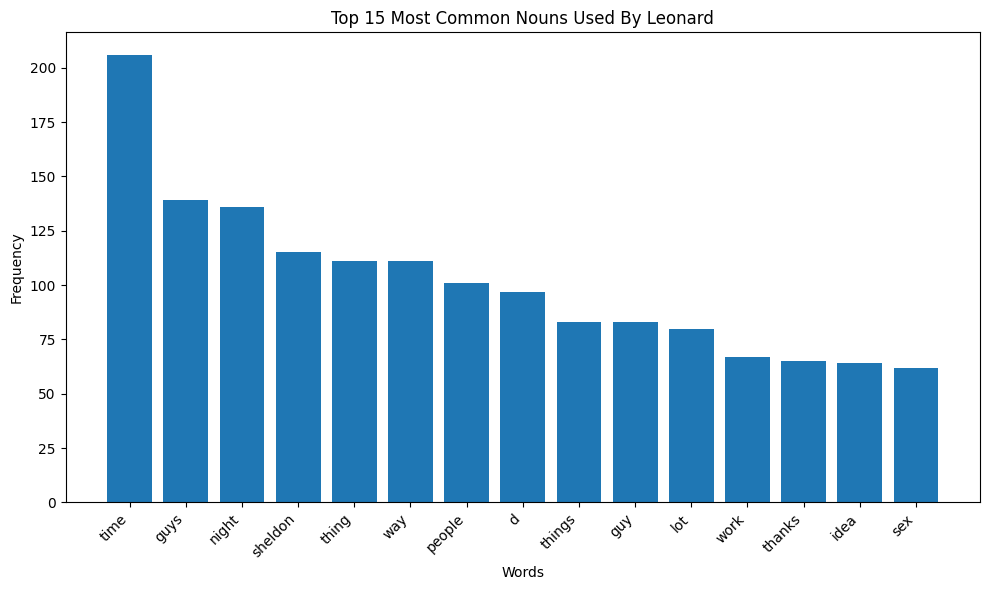

In [76]:
#Generate bar chart for nouns
top_15_nouns = nouncounts.most_common(15)

# Separate the data into labels and values for plotting
labels, values = zip(*top_15_nouns)

# Plot the bar chart
plt.figure(figsize=(10, 6))  # Increased figure size for better readability
plt.bar(labels, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Common Nouns Used By Leonard')

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Adjust layout to ensure labels fit within the figure
plt.tight_layout()

# Display the plot
plt.show()

##### Names

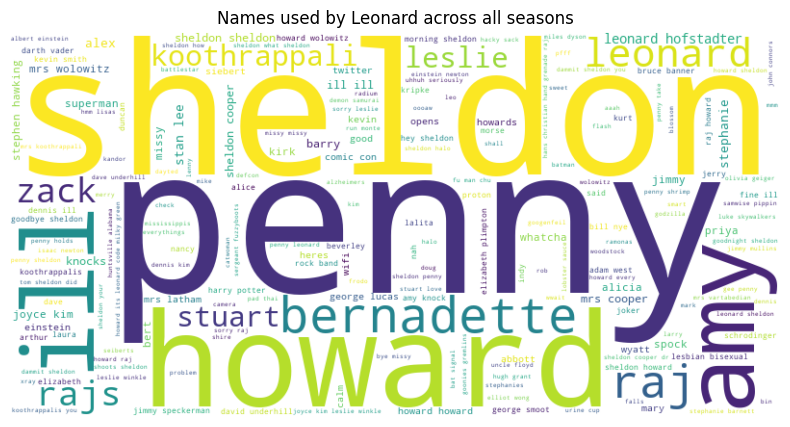

In [77]:
# Generate word cloud for names
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(namecounts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Names used by Leonard across all seasons")
plt.axis("off")
plt.show()

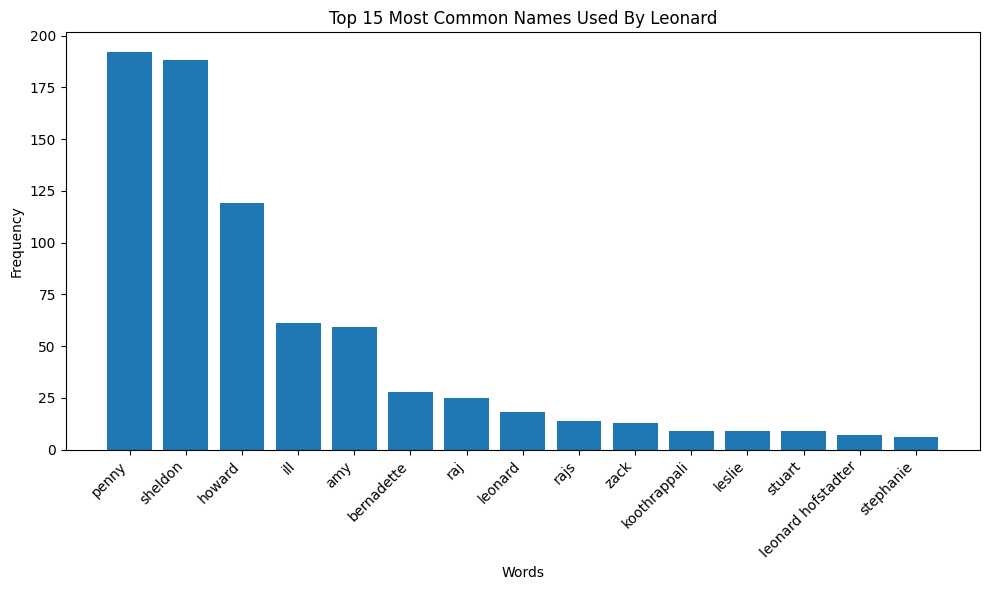

In [78]:
#Generate bar chart for names
top_15_names = namecounts.most_common(15)

# Separate the data into labels and values for plotting
labels, values = zip(*top_15_names)

# Plot the bar chart
plt.figure(figsize=(10, 6))  # Adjusted figure size for better readability
plt.bar(labels, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Common Names Used By Leonard')

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Adjust layout to ensure labels fit within the figure
plt.tight_layout()

# Display the plot
plt.show()

### 2.3 Question 3

#### 2.3.1 Analysis based on Bag of Words

In order to apply countvectorizer for the Bag of Words, i will transform the pre-processed words again into a verctor

In [79]:
# Join the processed words back into a single string for each dialogue
leonard["processed_dialogue"] = leonard["words"].apply(lambda x: " ".join(x))

# Check the new 'processed_dialogue' column
print(leonard[['dialogue', 'processed_dialogue']].head())

                                             dialogue  \
2                             Agreed whats your point   
4                                           Excuse me   
6    One across is Aegean eight down is Nabakov tw...   
8               Yes Um is this the High IQ sperm bank   
12                        Thankyou Well be right back   

                                   processed_dialogue  
2                                agre what your point  
4                                            excus me  
6   one across is aegean eight down is nabakov twe...  
8                 ye um is thi the high iq sperm bank  
12                        thankyou well be right back  


C:\Users\bryce\AppData\Local\Temp\ipykernel_32028\3290730351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leonard["processed_dialogue"] = leonard["words"].apply(lambda x: " ".join(x))


In [80]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the processed dialogue into a word count matrix
X = vectorizer.fit_transform(leonard["processed_dialogue"])

# Convert the word count matrix to a DataFrame for easy viewing
word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Check the word frequency DataFrame
print(word_freq_df.head())

   000318914  10  100  104  10th  11  12  128  13  14  ...  zebra  zelda  zen  \
0          0   0    0    0     0   0   0    0   0   0  ...      0      0    0   
1          0   0    0    0     0   0   0    0   0   0  ...      0      0    0   
2          0   0    0    0     0   0   0    0   0   0  ...      0      0    0   
3          0   0    0    0     0   0   0    0   0   0  ...      0      0    0   
4          0   0    0    0     0   0   0    0   0   0  ...      0      0    0   

   zero  zerograv  zip  zod  zombi  zone  zoo  
0     0         0    0    0      0     0    0  
1     0         0    0    0      0     0    0  
2     0         0    0    0      0     0    0  
3     0         0    0    0      0     0    0  
4     0         0    0    0      0     0    0  

[5 rows x 5627 columns]


##### 1) Most frequent words of the first 10 seasons

In [81]:
# Sum word counts across all dialogues to find the most frequent words
total_word_freq = word_freq_df.sum(axis=0)

# Sort the words by frequency
sorted_word_freq = total_word_freq.sort_values(ascending=False)

# Display the top 10 most frequent words
print(sorted_word_freq.head(10))

you     3643
to      2442
the     2344
it      2080
that    1508
and     1387
what    1126
of      1076
your     994
do       905
dtype: int64


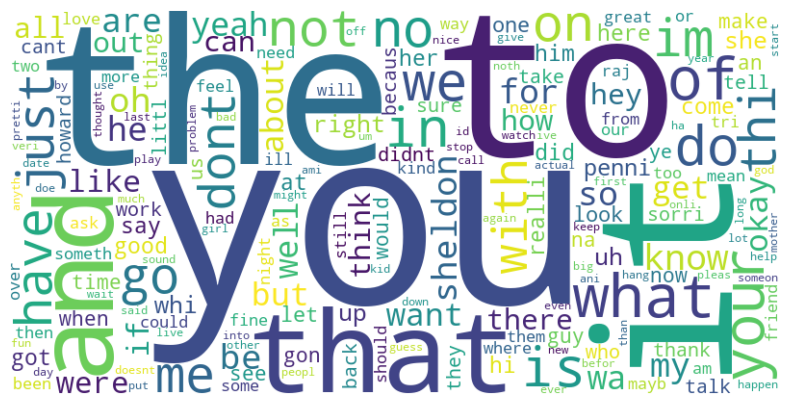

In [83]:
# Generate a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(total_word_freq)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### 2) Most frequent words per episodes

In [84]:
# Fit and transform the processed dialogue for each episode
# Iterate over each episode to get the top 10 words per episode
top_words_per_episode = {}

for episode in leonard['episode_name'].unique():
    # Get the processed dialogues for the current episode
    episode_dialogues = leonard[leonard['episode_name'] == episode]['processed_dialogue']
    
    # Fit and transform the processed dialogues into a word count matrix
    X = vectorizer.fit_transform(episode_dialogues)
    
    # Convert the word count matrix to a DataFrame
    word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Sum word counts across all dialogues in the episode
    total_word_freq = word_freq_df.sum(axis=0)
    
    # Sort words by frequency
    sorted_word_freq = total_word_freq.sort_values(ascending=False)
    
    # Get the top 10 words for the current episode
    top_words_per_episode[episode] = sorted_word_freq.head(10)

# Print the top 10 words for each episode
for episode, top_words in top_words_per_episode.items():
    print(f"Top 10 Words for {episode}:")
    print(top_words)
    print("\n")

Top 10 Words for Series 01 Episode 01 – Pilot Episode:
to      34
the     24
you     23
is      22
that    22
it      20
and     18
have    17
im      16
we      15
dtype: int64


Top 10 Words for Series 01 Episode 02 – The Big Bran Hypothesis:
the     27
to      26
you     21
it      20
and     17
no      14
of      14
is      13
we      13
have    11
dtype: int64


Top 10 Words for Series 01 Episode 03 – The Fuzzy Boots Corollary:
the     46
you     35
to      25
it      22
and     22
of      18
no      16
im      16
go      16
your    14
dtype: int64


Top 10 Words for Series 01 Episode 04 – The Luminous Fish Effect:
you        16
the        12
your        9
to          9
sheldon     6
that        6
is          6
what        6
with        6
are         5
dtype: int64


Top 10 Words for Series 01 Episode 05 – The Hamburger Postulate:
you       26
to        19
that      17
she       15
me        14
the       13
lesley    12
no        12
for       11
im        11
dtype: int64


Top 10 

I would like to visualize the evolution of most important words used by Leonard across the episodes. I think this can be more informative than making wordclouds for every episode. In order to avoid an overload of information i selected the first 5 and last 5 episodes. This selection provides the necessary descriptive characteristics of the evolution.

In [85]:
# Sort episodes based on their order (assuming episode_name has a sortable format)
sorted_episodes = sorted(leonard['episode_name'].unique())

# Get the first 5 and last 5 episodes
selected_episodes = sorted_episodes[:5] + sorted_episodes[-5:]

# Filter the top words data to include only these episodes
filtered_top_words = {episode: top_words_per_episode[episode] for episode in selected_episodes}

In [86]:
# Function to extract series and episode numbers and format as "Sxx Exx"
def format_episode_label(episode_name):
    match = re.match(r"Series (\d{2}) Episode (\d{2})", episode_name)
    if match:
        series_num = match.group(1)  # Extract series number
        episode_num = match.group(2)  # Extract episode number
        return f"S{series_num} E{episode_num}"
    return episode_name  # Return the original if no match is found

# Apply the function to the episode_name column to create the new labels
short_episode_labels = leonard['episode_name'].apply(format_episode_label).unique()

# Example of checking the result
print(short_episode_labels)

['S01 E01' 'S01 E02' 'S01 E03' 'S01 E04' 'S01 E05' 'S01 E06' 'S01 E07'
 'S01 E08' 'S01 E09' 'S01 E10' 'S01 E11' 'S01 E12' 'S01 E13' 'S01 E14'
 'S01 E15' 'S01 E16' 'S01 E17' 'S02 E01' 'S02 E02' 'S02 E03' 'S02 E04'
 'S02 E05' 'S02 E06' 'S02 E07' 'S02 E08' 'S02 E09' 'S02 E10' 'S02 E11'
 'S02 E12' 'S02 E13' 'S02 E14' 'S02 E15' 'S02 E16' 'S02 E17' 'S02 E18'
 'S02 E19' 'S02 E20' 'S02 E21' 'S02 E22' 'S02 E23' 'S03 E01' 'S03 E02'
 'S03 E03' 'S03 E04' 'S03 E05' 'S03 E06' 'S03 E07' 'S03 E08' 'S03 E09'
 'S03 E10' 'S03 E11' 'S03 E12' 'S03 E13' 'S03 E14' 'S03 E15' 'S03 E16'
 'S03 E17' 'S03 E18' 'S03 E19' 'S03 E20' 'S03 E21' 'S03 E22' 'S03 E23'
 'S04 E01' 'S04 E02' 'S04 E03' 'S04 E04' 'S04 E05' 'S04 E06' 'S04 E07'
 'S04 E08' 'S04 E09' 'S04 E10' 'S04 E11' 'S04 E12' 'S04 E13' 'S04 E14'
 'S04 E15' 'S04 E16' 'S04 E17' 'S04 E18' 'S04 E19' 'S04 E20' 'S04 E21'
 'S04 E22' 'S04 E23' 'S04 E24' 'S05 E01' 'S05 E02' 'S05 E03' 'S05 E04'
 'S05 E05' 'S05 E06' 'S05 E07' 'S05 E08' 'S05 E09' 'S05 E10' 'S05 E11'
 'S05 

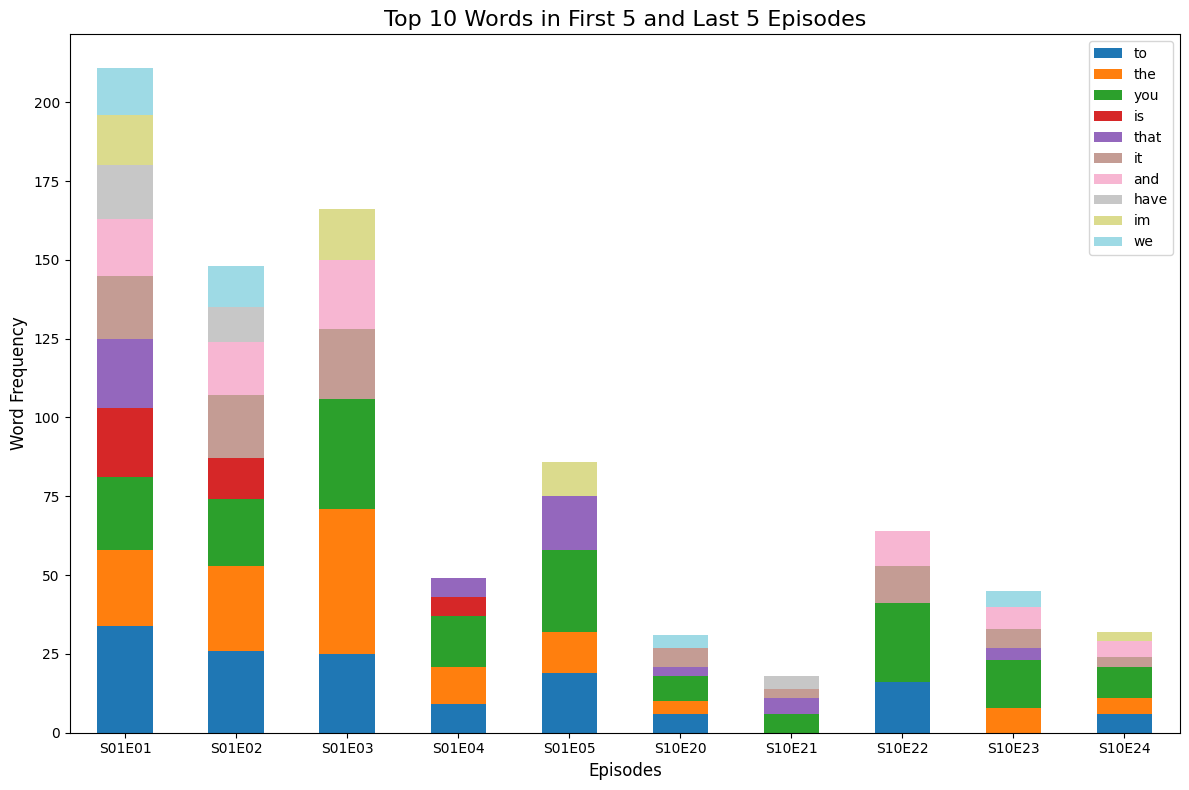

In [87]:
# Create an empty DataFrame to store the word frequencies for the selected episodes
filtered_top_words_df = pd.DataFrame(columns=filtered_top_words[next(iter(filtered_top_words))].index)

# Fill the DataFrame with the word frequencies for the selected episodes
for episode, top_words in filtered_top_words.items():
    filtered_top_words_df.loc[episode] = top_words

# Plot the stacked bar chart
filtered_top_words_df.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')

# Set the title and labels
plt.title("Top 10 Words in First 5 and Last 5 Episodes", fontsize=16)
plt.xlabel("Episodes", fontsize=12)  # Set custom label here
plt.ylabel("Word Frequency", fontsize=12)

# Custom x-axis labels as you requested
custom_labels = ['S01E01', 'S01E02', 'S01E03', 'S01E04', 'S01E05', 
                 'S10E20', 'S10E21', 'S10E22', 'S10E23', 'S10E24']

# Set the x-ticks and labels
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

##### 3) Most frequent words per season

In [88]:
# Initialize a dictionary to store top words for each season
top_words_per_season = {}

# Iterate over each season to get the top 10 words
for season in leonard['Season'].unique():
    # Get the processed dialogues for the current season
    season_dialogues = leonard[leonard['Season'] == season]['processed_dialogue']
    
    # Fit and transform the processed dialogues into a word count matrix
    X = vectorizer.fit_transform(season_dialogues)
    
    # Convert the word count matrix to a DataFrame
    word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Sum word counts across all dialogues in the season
    total_word_freq = word_freq_df.sum(axis=0)
    
    # Sort words by frequency
    sorted_word_freq = total_word_freq.sort_values(ascending=False)
    
    # Get the top 10 words for the current season
    top_words_per_season[season] = sorted_word_freq.head(10)

# Print the top 10 words for each season
for season, top_words in top_words_per_season.items():
    print(f"Top 10 Words for Season {season}:")
    print(top_words)
    print("\n")

Top 10 Words for Season Series 01:
you     342
the     316
to      307
it      222
and     168
that    155
is      135
of      134
go      122
what    120
dtype: int64


Top 10 Words for Season Series 02:
you     444
to      334
the     310
it      248
and     172
that    164
what    158
of      136
go      134
your    112
dtype: int64


Top 10 Words for Season Series 03:
you     432
to      316
the     260
it      241
and     163
that    160
what    154
of      124
do      113
go      111
dtype: int64


Top 10 Words for Season Series 04:
you     375
to      259
the     248
it      181
that    152
what    139
your    114
of      111
and     108
no      105
dtype: int64


Top 10 Words for Season Series 05:
you     413
to      221
it      214
the     204
that    153
and     135
what    119
in      115
do      111
of      109
dtype: int64


Top 10 Words for Season Series 06:
you     321
to      224
the     217
it      165
that    144
and     130
of       99
what     95
do       89
your   

The following graph makes these insights visually appealing. It visualizes the top 10 words for every season and allows to define a longitudinal trend. There are multiple trends visible. First, the majority of the most frequent words stay the same across the seasons, meaning that the these words have been re-used multiple times throughout the episodes. Second, some terms were kicked out and replace by another word. As an illustration, "go" seemed to be an important word during the first three seasons and is most probably replaced by the word "do" in the eppisodes that folow. This could give an indication of the character development thoughout the series.

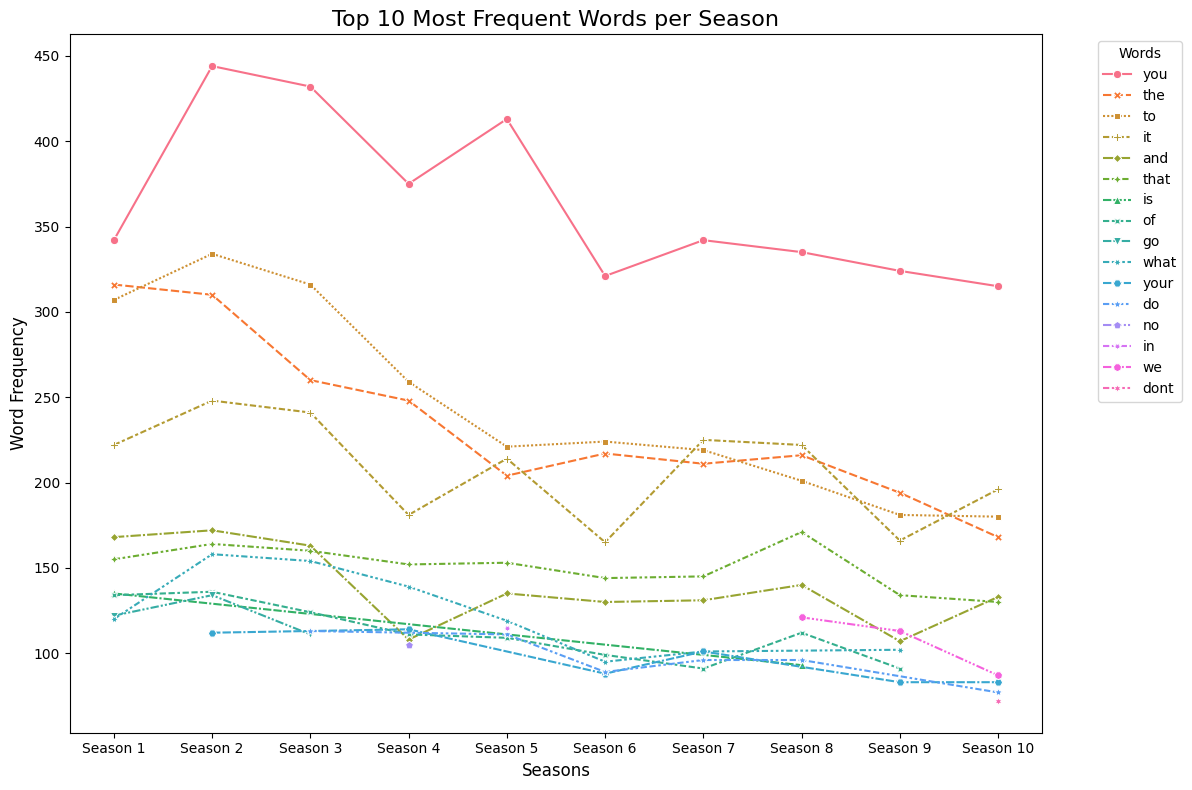

In [89]:
# Create a DataFrame to store the word frequencies for all seasons
# Initialize a list to collect all words, preserving their order
all_words = []

# Collect all unique words across seasons for the plot
for season, top_words in top_words_per_season.items():
    all_words.extend(top_words.index)

# Remove duplicates by converting to a set and then back to a list (to maintain order)
all_words = list(dict.fromkeys(all_words))

# Create a DataFrame where rows are words and columns are seasons
word_frequencies_df = pd.DataFrame(index=all_words)

# Populate the DataFrame with the top word frequencies per season
for season, top_words in top_words_per_season.items():
    for word, freq in top_words.items():
        word_frequencies_df.at[word, f'Season {season}'] = freq

# Fill NaN values with 0 (in case a word is not in a particular season's top 10)
word_frequencies_df = word_frequencies_df.fillna(0)

# Replace zeros with NaN so they are treated as missing values
word_frequencies_df = word_frequencies_df.replace(0, pd.NA)

# Plot the line graph
plt.figure(figsize=(12, 8))  # Set figure size
sns.lineplot(data=word_frequencies_df.T, markers=True, linestyle='-', marker='o')

# Add labels and title
plt.title('Top 10 Most Frequent Words per Season', fontsize=16)
plt.xlabel('Seasons', fontsize=12)
plt.ylabel('Word Frequency', fontsize=12)

# Custom x-axis labels as you requested
custom_labels = ['Season 1', 'Season 2', 'Season 3', 'Season 4', 'Season 5', 
                 'Season 6', 'Season 7', 'Season 8', 'Season 9', 'Season 10']

# Set the x-ticks and labels
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=0)

# Adjust the legend and layout
plt.legend(title='Words', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

The Term Frequency - Inverse Document Frequency technique has also been applied on this dataset.

#### 2.3.2 Analysis based on Term Frequency - Inverse Document Frequency

In [90]:
def get_top_tfidf_words(tfidf_matrix, feature_names, top_n=10):
    top_words = []
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix[i].toarray().flatten()
        top_indices = row.argsort()[-top_n:][::-1]
        top_terms = [(feature_names[idx], row[idx]) for idx in top_indices]
        top_words.append(top_terms)
    return top_words

# Aggregate dialogues by episode
episode_dialogues = leonard.groupby('episode_name')['dialogue'].apply(' '.join).reset_index()

In [91]:
# Vectorize dialogues per episode
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_episode = tfidf_vectorizer.fit_transform(episode_dialogues['dialogue'])
feature_names_episode = tfidf_vectorizer.get_feature_names_out()

##### 1) Most frequent words per episode (and rarest words)

In [92]:
# Top N frequent and rarest words
def get_top_and_rare_words(tfidf_matrix, feature_names, top_n=10):
    frequent_words = []
    rarest_words = []
    
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix[i].toarray().flatten()
        
        # Get top N frequent words
        top_indices = row.argsort()[-top_n:][::-1]
        frequent_terms = [(feature_names[idx], row[idx]) for idx in top_indices if row[idx] > 0]
        frequent_words.append(frequent_terms)
        
        # Get top N rarest words (non-zero scores)
        rare_indices = [idx for idx in row.argsort() if row[idx] > 0][:top_n]
        rare_terms = [(feature_names[idx], row[idx]) for idx in rare_indices]
        rarest_words.append(rare_terms)
    
    return frequent_words, rarest_words

# Get top frequent and rare words per episode
frequent_words_per_episode, rarest_words_per_episode = get_top_and_rare_words(tfidf_matrix_episode, feature_names_episode)

# Add results to DataFrame
episode_dialogues['Top_10_Frequent_Words'] = frequent_words_per_episode
episode_dialogues['Top_10_Rarest_Words'] = rarest_words_per_episode

# Display sample output
print("Most Frequent and Rarest Words per Episode:")
print(episode_dialogues[['episode_name', 'Top_10_Frequent_Words', 'Top_10_Rarest_Words']].head())


Most Frequent and Rarest Words per Episode:
                                       episode_name  \
0              Series 01 Episode 01 – Pilot Episode   
1    Series 01 Episode 02 – The Big Bran Hypothesis   
2  Series 01 Episode 03 – The Fuzzy Boots Corollary   
3   Series 01 Episode 04 – The Luminous Fish Effect   
4    Series 01 Episode 05 – The Hamburger Postulate   

                               Top_10_Frequent_Words  \
0  [(to, 0.24754113920842855), (the, 0.1739833725...   
1  [(the, 0.22068722738129035), (to, 0.2134316132...   
2  [(the, 0.2838047656354453), (you, 0.2159384086...   
3  [(fish, 0.3051467253777617), (you, 0.223586759...   
4  [(lesley, 0.5288741837233881), (you, 0.2142608...   

                                 Top_10_Rarest_Words  
0  [(yeah, 0.008659036055666305), (want, 0.009460...  
1  [(with, 0.009184899355162576), (hey, 0.0102026...  
2  [(how, 0.008197907704835378), (got, 0.00902703...  
3  [(have, 0.015635159398447007), (oh, 0.01570316...  
4  [(its, 0.0

### 2.4 Question 4

#### Data preparation

As tags "\<S\>" and "\<E\>" might inflate the significance of rare word pairs if they frequently co-occur with other words in the text, here we do not include them at the beginning and end of each sentence. For the same reason, we remove stop words for this question.

In [93]:
# Flatten the sentences into a single column
leonard_exploded = leonard.explode("sentences")

#Delete punctuation
leonard_exploded["sentences"] = leonard_exploded["sentences"].apply(lambda x : re.sub(r"[^\w\s]", "", x))

#Tokenize Words
leonard_exploded["words"] = leonard_exploded["sentences"].apply(lambda x : word_tokenize(x))

#Applying PorterStemmer
leonard_exploded["words"] = leonard_exploded["words"].apply(lambda x : stemmer(x))

#Lowercase
leonard_exploded["words"] = leonard_exploded["words"].apply(
    lambda words: [word.lower() for word in words]
)

#Remove stopwords
leonard_exploded["words"] = leonard_exploded["words"].apply(lambda x : remove_stopwords(x))

#leonard_exploded["words"] = leonard_exploded["words"].apply(
#   lambda words: ['<S>'] + words + ['<E>']  # Add <S> and <E> to the entire list of words
#)

In [94]:
# Create a new dataframe that will be need for this question and examine the words column
words_df = pd.DataFrame(leonard_exploded["words"])
words_df.head()

,words
2,"[agre, point]"
4,[excus]
6,"[one, across, aegean, eight, nabakov, twentysi..."
6,"[see, papa, doc, capit, idea, portauprinc]"
6,[haiti]


#### 2.4.1 Create Word-Word Co-occurrence Matrix

In [95]:
# Flatten the data to get a unique vocabulary
all_words = sorted(set(word for sentence in words_df['words'] for word in sentence))

In [96]:
# Create a mapping of words to indices
word_to_idx = {word: i for i, word in enumerate(all_words)}

# Initialize an empty co-occurrence matrix
co_occurrence_matrix = np.zeros((len(all_words), len(all_words)), dtype=int)

# Populate the co-occurrence matrix
for sentence in words_df['words']:
    for i in range(len(sentence) - 1):
        # Get indices for the current word and the next word
        word_idx_1 = word_to_idx[sentence[i]]
        word_idx_2 = word_to_idx[sentence[i + 1]]
        
        # Increment co-occurrence count for the pair
        co_occurrence_matrix[word_idx_1, word_idx_2] += 1
        co_occurrence_matrix[word_idx_2, word_idx_1] += 1  # Since it's symmetric

# Convert the matrix to a DataFrame for better readability
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=all_words, columns=all_words)
co_occurrence_df

,000318914,1,10,100,104,10th,11,12,128,13,...,zebra,zelda,zen,zero,zerograv,zip,zod,zombi,zone,zoo
000318914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zod,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zombi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here, the Word-Word co-occurrence matrix appears to be very sparse. To gain insights from it, we will examine the top co-occurring word pairs.

In [97]:
# Flatten the co-occurrence DataFrame into word pairs with counts
pairs_with_counts = []
for i, word_i in enumerate(co_occurrence_df.index):
    for j, word_j in enumerate(co_occurrence_df.columns):
        if i < j:  # Avoid duplicates (symmetry)
            pairs_with_counts.append(((word_i, word_j), co_occurrence_df.iloc[i, j]))

In [98]:
# Sort by co-occurrence count in descending order
sorted_pairs = sorted(pairs_with_counts, key=lambda x: x[1], reverse=True)

In [38]:
# Get the top 20 word pairs with highest counts
top_20_pairs = sorted_pairs[:20]

# Display as a DataFrame
top_20_df = pd.DataFrame({
    "Word Pair": [f"{pair[0]} - {pair[1]}" for pair, _ in top_20_pairs],
    "Co-occurrence Count": [count for _, count in top_20_pairs]
})

print(top_20_df)

       Word Pair  Co-occurrence Count
0       gon - na                  228
1    dont - know                  156
2     im - sorri                  101
3        go - im                   71
4    dont - want                   67
5   dont - think                   65
6       gon - im                   64
7     dont - whi                   47
8       go - let                   47
9       god - oh                   45
10     im - sure                   38
11     oh - yeah                   36
12   whi - would                   35
13  last - night                   32
14   okay - well                   31
15  good - night                   30
16   like - look                   30
17  like - sound                   28
18  book - comic                   26
19     uh - yeah                   26


To visualize the result of the top co-occurring word pairs, we can use a bar chart.

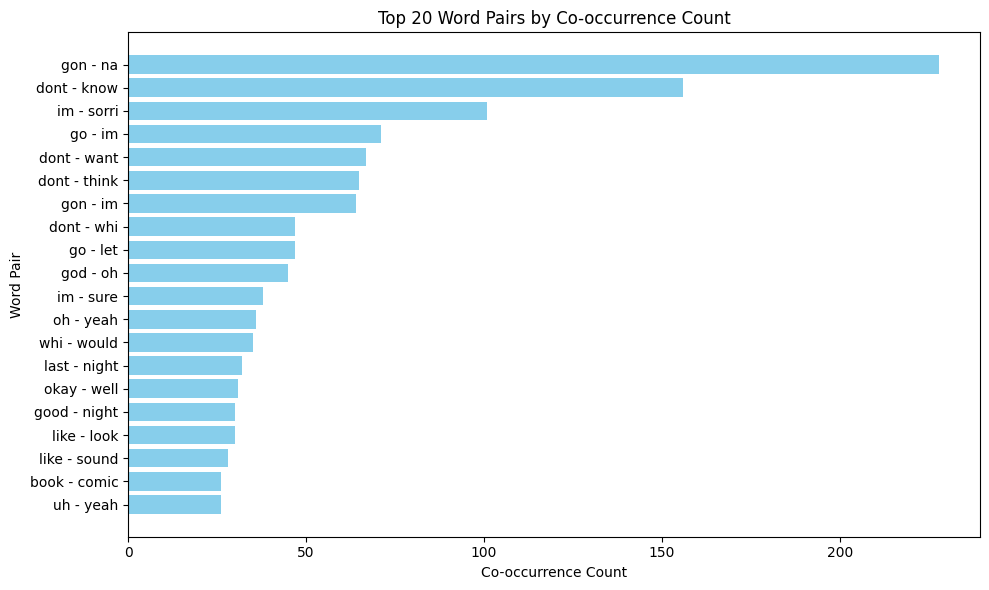

In [39]:
# Extract data for plotting
word_pairs = top_20_df["Word Pair"]
counts = top_20_df["Co-occurrence Count"]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(word_pairs, counts, color='skyblue')
plt.xlabel('Co-occurrence Count')
plt.ylabel('Word Pair')
plt.title('Top 20 Word Pairs by Co-occurrence Count')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.tight_layout()
plt.show()

The results indicate that, except "comic book," the most commonly used word pairs consist of casual speech patterns. These pairs, while reflective of everyday conversational language, do not provide substantial insight into the character's deeper traits or themes. Hence, Pointwise Positive Mutual Information (PPMI) will be analyzed to uncover more meaningful insights.

#### 2.4.2 Calculate the Positive Pointwise Mutual Information measurement

In [40]:
# Total number of word co-occurrences
total_co_occurrences = co_occurrence_matrix.sum()

# Probability of each word (marginal probabilities)
word_probabilities = co_occurrence_matrix.sum(axis=1) / total_co_occurrences

# Initialize the PPMI matrix
ppmi_matrix = np.zeros_like(co_occurrence_matrix, dtype=float)

# Compute PPMI values
for i in range(len(all_words)):
    for j in range(len(all_words)):
        joint_probability = co_occurrence_matrix[i, j] / total_co_occurrences
        if joint_probability > 0:  # Avoid log of zero
            pmi = np.log2(joint_probability / (word_probabilities[i] * word_probabilities[j]))
            ppmi_matrix[i, j] = max(pmi, 0)  # PPMI is non-negative

# Convert the PPMI matrix to a DataFrame for better readability
ppmi_df = pd.DataFrame(ppmi_matrix, index=all_words, columns=all_words)
ppmi_df


,000318914,1,10,100,104,10th,11,12,128,13,...,zebra,zelda,zen,zero,zerograv,zip,zod,zombi,zone,zoo
000318914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zod,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zombi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Flatten the PPMI matrix into word pairs with their PPMI values
pairs_with_ppmi = []
for i in range(len(all_words)):
    for j in range(i + 1, len(all_words)):  # Ensure j > i to avoid duplicates
        pairs_with_ppmi.append(((all_words[i], all_words[j]), ppmi_matrix[i, j]))

In [42]:
# Sort pairs by PPMI values in descending order
sorted_pairs = sorted(pairs_with_ppmi, key=lambda x: x[1], reverse=True)

# Get the top 5 word pairs with highest PPMI values
top_5_pairs = sorted_pairs[:5]

# Display the results
for pair, ppmi_value in top_5_pairs:
    print(f"Words: {pair}, PPMI: {ppmi_value}")

Words: ('abracomanch', 'tribe'), PPMI: 16.126623819032357
Words: ('acetylen', 'torch'), PPMI: 16.126623819032357
Words: ('alter', 'timelin'), PPMI: 16.126623819032357
Words: ('assless', 'chap'), PPMI: 16.126623819032357
Words: ('ay', 'papi'), PPMI: 16.126623819032357


It seems that there are lots of word pairs have the same PPMI, therefore we will display all the pairs with the highest PPMI.

In [43]:
# Make pairs_with_ppmi into a dataframe
words_ppmi_df = pd.DataFrame(pairs_with_ppmi, columns=['Word Pair', 'PPMI'])

# Find the maximum PPMI value in the DataFrame
max_ppmi_value = words_ppmi_df['PPMI'].max()

# Filter all word pairs that have the highest PPMI value
highest_ppmi_pairs = words_ppmi_df[words_ppmi_df['PPMI'] == max_ppmi_value]

# Print all word pairs with the highest PPMI value
print('Total number of pairs:', len(highest_ppmi_pairs))
print(highest_ppmi_pairs[['Word Pair', 'PPMI']])

Total number of pairs: 21
                      Word Pair       PPMI
642111     (abracomanch, tribe)  16.126624
745122        (acetylen, torch)  16.126624
1292166        (alter, timelin)  16.126624
1949462         (assless, chap)  16.126624
2189622              (ay, papi)  16.126624
3598382        (briefli, howev)  16.126624
4909266       (clarenc, darrow)  16.126624
6259973      (damsel, distress)  16.126624
6731231        (deviat, septum)  16.126624
7347693          (ds, nintendo)  16.126624
7934374            (eta, meson)  16.126624
8101797       (exhibit, vendor)  16.126624
8726421       (flintston, fred)  16.126624
9334495        (geiger, olivia)  16.126624
9342649       (gelatin, sphere)  16.126624
9486772     (glaringli, obviou)  16.126624
12456282   (miracl, saturnalia)  16.126624
12544426   (mona, mouthtomouth)  16.126624
12675330      (murdoch, rupert)  16.126624
13731484  (poptart, strawberri)  16.126624
14568372    (seedi, underbelli)  16.126624


In [44]:
# Check the co-occurence of the word pairs with highest ppmi
co_occurrence_df.loc["abracomanch","tribe"]

1

We can infer that all the word pairs with the highest PPMI have a co-occurrence of 1. This outcome is expected, as PPMI tends to be biased toward infrequent events. Despite this limitation, the results still highlight that Leonard's dialogue often revolves around niche topics, which aligns with his portrayal as a nerdy character.